In [1]:
# core
import os, glob, random, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

# viz + scaling
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# paths
DATA_DIR = "../data/raw/gait-in-parkinsons-disease-1.0.0"
PROC_DIR = "../data/processed"
FIG_DIR  = "../reports/figs"
os.makedirs(PROC_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# reproducibility
seed = 42
np.random.seed(seed); random.seed(seed)
print("env ok.")

env ok.


In [2]:
# =============================
# 1) Imports & style
# =============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(style="whitegrid", context="talk", palette="Set2")
plt.rcParams["figure.dpi"] = 130

# =============================
# 2) Load data
#    (change the paths if needed)
# =============================
xls_path = r"C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/data/raw/gait-in-parkinsons-disease-1.0.0/demographics.xls"
csv_path = r"C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/data/processed/subject_overview.csv"

# For .xls you need xlrd installed. If import fails, install xlrd==1.2.0
demo = pd.read_excel(xls_path)         # original (has ID, UPDRS)
overview = pd.read_csv(csv_path)       # cleaned (has subject_id, group, age, sex)

# =============================
# 3) Normalize & merge
# =============================
# lowercase column names
demo.columns = [str(c).strip().lower() for c in demo.columns]
overview.columns = [str(c).strip().lower() for c in overview.columns]

# keep only needed cols
need_over = ["subject_id", "group", "age", "sex"]
need_demo  = ["id", "updrs"]

# Map possible synonyms safely
col_over = {
    "subject_id": next(c for c in overview.columns if c in ["subject_id","subjectid","subj_id","id"]),
    "group":      next(c for c in overview.columns if c in ["group","grp","diagnosis","cohort"]),
    "age":        next(c for c in overview.columns if c in ["age","age_years","years"]),
    "sex":        next(c for c in overview.columns if c in ["sex","gender"])
}
col_demo = {
    "id":    next(c for c in demo.columns if c in ["id","subject_id","subjectid"]),
    "updrs": next(c for c in demo.columns if c in ["updrs","updrs_total","updrs_score"])
}

overview = overview.rename(columns={
    col_over["subject_id"]: "subject_id",
    col_over["group"]: "group",
    col_over["age"]: "age",
    col_over["sex"]: "sex"
})[["subject_id","group","age","sex"]].copy()

demo = demo.rename(columns={
    col_demo["id"]: "id",
    col_demo["updrs"]: "updrs"
})[["id","updrs"]].copy()

# standardize values
# group could be numeric (1=PD, 0=HC) or text
if pd.api.types.is_numeric_dtype(overview["group"]):
    overview["group"] = overview["group"].map({1:"PD", 0:"HC"}).astype("string")
else:
    overview["group"] = (overview["group"].astype(str).str.strip().str.upper()
                         .replace({"P.D.":"PD","PARKINSON":"PD","PATIENT":"PD",
                                   "HEALTHY":"HC","CONTROL":"HC","H.C.":"HC"}))

overview["sex"] = (overview["sex"].astype(str).str.strip().str.capitalize()
                   .replace({"M":"Male","F":"Female"}))
overview["age"] = pd.to_numeric(overview["age"], errors="coerce")
demo["updrs"]   = pd.to_numeric(demo["updrs"], errors="coerce")

# merge subject_overview (left) with UPDRS (right)
df = overview.merge(demo, left_on="subject_id", right_on="id", how="left")

# Drop rows with invalid age for plots
df = df.dropna(subset=["age"]).reset_index(drop=True)

# =============================
# 4) Summary table (counts + μ±σ)
# =============================
summary = (
    df.groupby(["group","sex"])
      .agg(Subjects=("subject_id","count"),
           Age_mean=("age","mean"),
           Age_std=("age","std"),
           UPDRS_mean=("updrs","mean"),
           UPDRS_std=("updrs","std"))
      .reset_index()
)
summary["Age (μ±σ)"]   = summary["Age_mean"].round(1).astype(str)   + " ± " + summary["Age_std"].round(1).astype(str)
summary["UPDRS (μ±σ)"] = summary["UPDRS_mean"].round(1).astype(str) + " ± " + summary["UPDRS_std"].round(1).astype(str)

display(summary[["group","sex","Subjects","Age (μ±σ)","UPDRS (μ±σ)"]].sort_values(["group","sex"]))


,group,sex,Subjects,Age (μ±σ),UPDRS (μ±σ)
0,HC,Female,32,63.9 ± 8.6,0.4 ± 0.7
1,HC,Male,40,63.5 ± 8.9,0.5 ± 1.1
2,PD,Female,35,65.0 ± 10.4,29.1 ± 12.9
3,PD,Male,58,67.1 ± 8.9,33.1 ± 11.0


In [3]:
import seaborn as sns
from pathlib import Path
from scipy import stats

# style
sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.dpi"] = 150

# subtle palette
COL_MALE   = "#1f4e79"   # dark blue
COL_FEMALE = "#2ca6a4"   # teal
COL_PD     = "#3a7bd5"   # blue for PD
COL_HC     = "#9aa0a6"   # gray for HC

outdir = Path(".")            # change if you want a specific folder
outdir.mkdir(exist_ok=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_13708\432353372.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sex", y="updrs", data=pd_only, order=order,


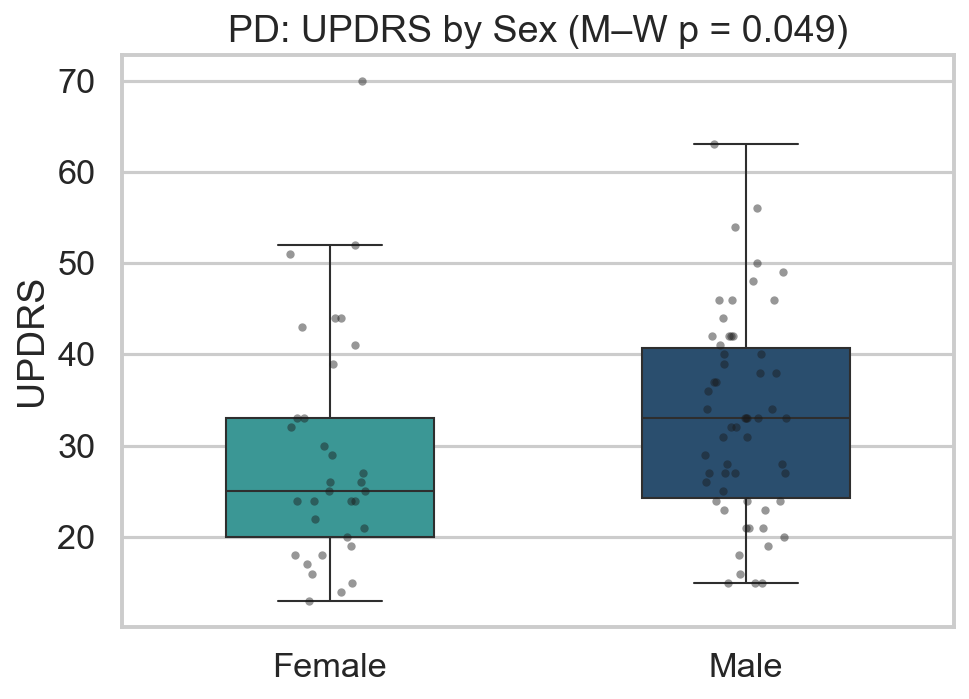

In [5]:
pd_only = df[(df["group"] == "PD") & (~df["updrs"].isna())].copy()
if len(pd_only) == 0:
    print("No PD UPDRS data to plot.")
else:
    # order and colors
    order  = ["Female", "Male"]
    colors = [COL_FEMALE, COL_MALE]

    plt.figure(figsize=(6.8, 5))
    sns.boxplot(x="sex", y="updrs", data=pd_only, order=order,
                showfliers=False, width=0.5, palette=colors)
    sns.stripplot(x="sex", y="updrs", data=pd_only, order=order,
                  color="k", alpha=0.45, size=4)

    # Mann–Whitney U (nonparametric)
    f = pd_only.loc[pd_only["sex"]=="Female", "updrs"].dropna().values
    m = pd_only.loc[pd_only["sex"]=="Male",   "updrs"].dropna().values
    title = "PD: UPDRS by Sex"
    if len(f) and len(m):
        U, p = stats.mannwhitneyu(f, m, alternative="two-sided")
        title += f" (M–W p = {p:.3f})"

    plt.title(title)
    plt.xlabel(""); plt.ylabel("UPDRS")
    plt.tight_layout()
    plt.savefig(outdir / "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/reports/figs/updrs_boxplot_pd.png", dpi=450)
    plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_13708\490624965.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="sex", y="updrs", data=pd_only, order=order,
C:\Users\admin\AppData\Local\Temp\ipykernel_13708\490624965.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"Female (n={n_f})", f"Male (n={n_m})"])


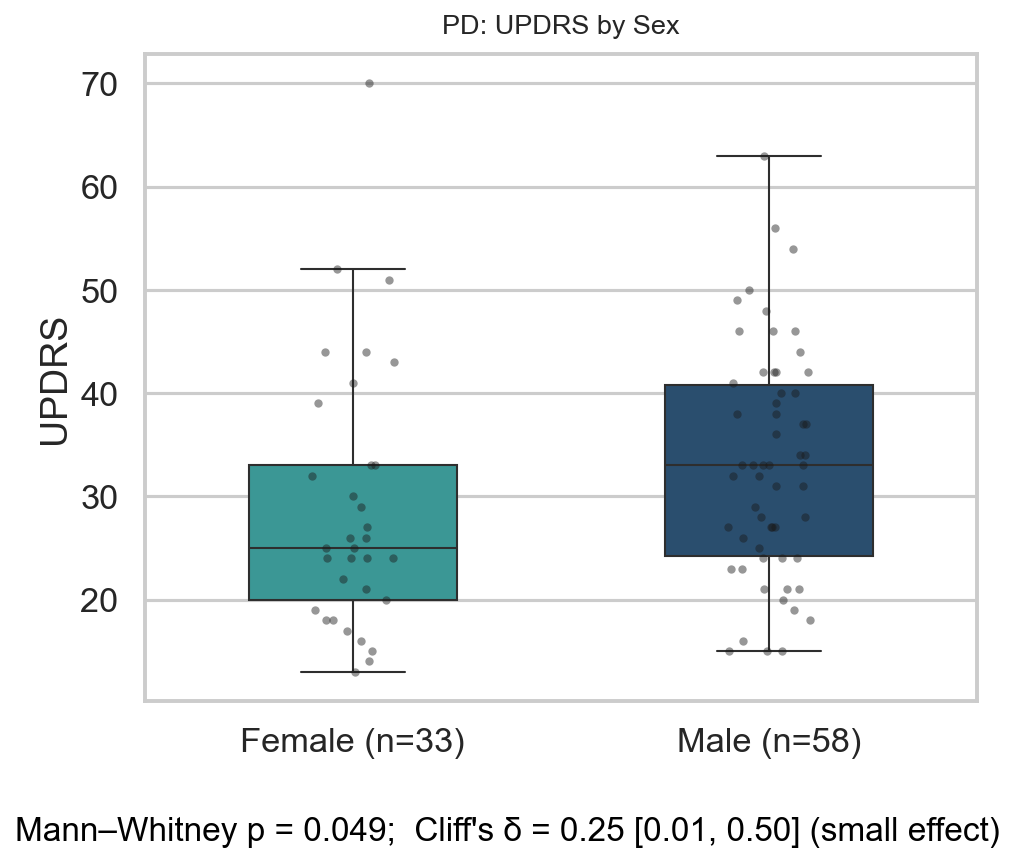

In [6]:
# --- PD: UPDRS by Sex (with effect size + stats note below plot) ---

pd_only = df[(df["group"] == "PD") & (~df["updrs"].isna())].copy()
if len(pd_only) == 0:
    print("No PD UPDRS data to plot.")
else:
    import numpy as np
    from scipy import stats
    import seaborn as sns
    import matplotlib.pyplot as plt
    rng = np.random.default_rng(42)

    order  = ["Female", "Male"]
    colors = [COL_FEMALE, COL_MALE]

    # Extract groups
    f = pd_only.loc[pd_only["sex"] == "Female", "updrs"].dropna().to_numpy()
    m = pd_only.loc[pd_only["sex"] == "Male",   "updrs"].dropna().to_numpy()
    n_f, n_m = len(f), len(m)

    # Mann–Whitney U
    U, p = stats.mannwhitneyu(m, f, alternative="two-sided")

    # Cliff's delta + CI
    def cliffs_delta(x, y):
        gt = np.sum(x[:, None] > y)
        lt = np.sum(x[:, None] < y)
        return (gt - lt) / (len(x) * len(y))

    delta = cliffs_delta(m, f)

    B = 5000
    deltas = np.empty(B)
    for b in range(B):
        xb = np.random.choice(m, n_m, replace=True)
        yb = np.random.choice(f, n_f, replace=True)
        deltas[b] = cliffs_delta(xb, yb)
    lo, hi = np.percentile(deltas, [2.5, 97.5])

    # Qualitative label
    def delta_qual(d):
        ad = abs(d)
        if ad < 0.147:  return "negligible"
        if ad < 0.33:   return "small"
        if ad < 0.474:  return "medium"
        return "large"

    # --- Plot ---
    plt.figure(figsize=(6.8, 5.5))
    ax = sns.boxplot(x="sex", y="updrs", data=pd_only, order=order,
                     showfliers=False, width=0.5, palette=colors)
    sns.stripplot(x="sex", y="updrs", data=pd_only, order=order,
                  color="k", alpha=0.45, size=4)

    ax.set_xticklabels([f"Female (n={n_f})", f"Male (n={n_m})"])
    plt.title("PD: UPDRS by Sex", fontsize=13, pad=10)
    plt.ylabel("UPDRS")
    plt.xlabel("")

    # Add text box with stats below plot
    plt.figtext(
        0.5, -0.05,
        f"Mann–Whitney p = {p:.3f};  Cliff's δ = {delta:.2f} "
        f"[{lo:.2f}, {hi:.2f}] ({delta_qual(delta)} effect)",
        wrap=True, ha="center", fontsize=16, color="black"
    )

    plt.tight_layout()
    plt.savefig(outdir / "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/reports/figs/updrs_boxplot_pd_statsbelow.png",
                dpi=450, bbox_inches="tight", transparent=True)
    plt.show()

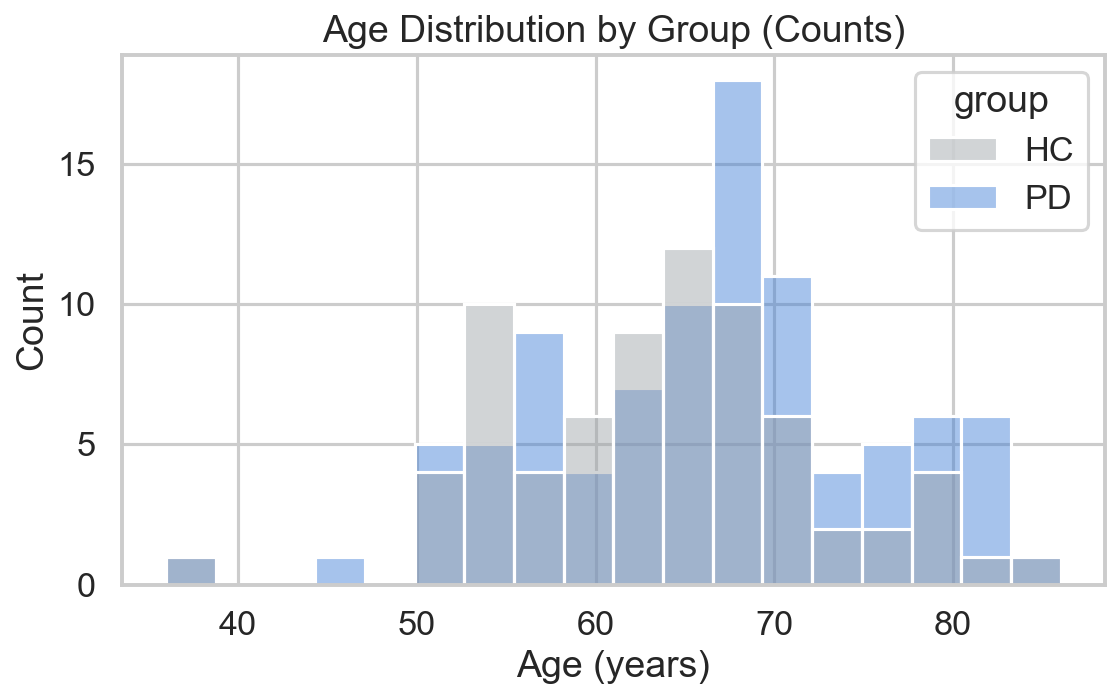

In [7]:
plt.figure(figsize=(8,5))
sns.histplot(df.dropna(subset=["age"]) , x="age", hue="group",
             bins=18, multiple="layer",
             palette={"PD":COL_PD, "HC":COL_HC},
             alpha=0.45, edgecolor=None, stat="count")
plt.title("Age Distribution by Group (Counts)")
plt.xlabel("Age (years)"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig(outdir / "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/reports/figs/age_distribution.png", dpi=450)
plt.show()


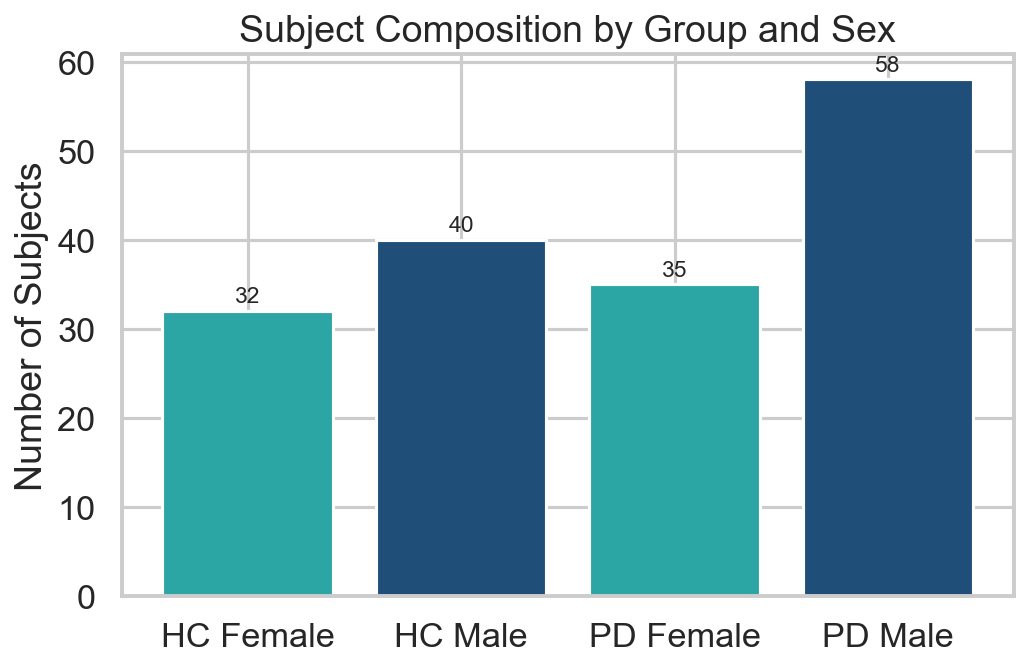

In [8]:
# counts by group & sex
counts = df.groupby(["group","sex"])["subject_id"].count().rename("n").reset_index()

# explicit order for neat categories
cat_order = ["HC Female","HC Male","PD Female","PD Male"]
counts["cat"] = counts["group"].astype(str) + " " + counts["sex"].astype(str)
counts = counts.set_index("cat").reindex(cat_order).reset_index()

color_map = [COL_FEMALE, COL_MALE, COL_FEMALE, COL_MALE]

plt.figure(figsize=(7.2,4.8))
bars = plt.bar(counts["cat"], counts["n"], color=color_map)
plt.title("Subject Composition by Group and Sex")
plt.ylabel("Number of Subjects"); plt.xlabel("")
plt.xticks(rotation=0)

# annotate counts on top
for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 0.5, f"{int(h)}",
             ha="center", va="bottom", fontsize=11)

plt.tight_layout()
plt.savefig(outdir / "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/reports/figs/sex_distribution.png", dpi=450)
plt.show()

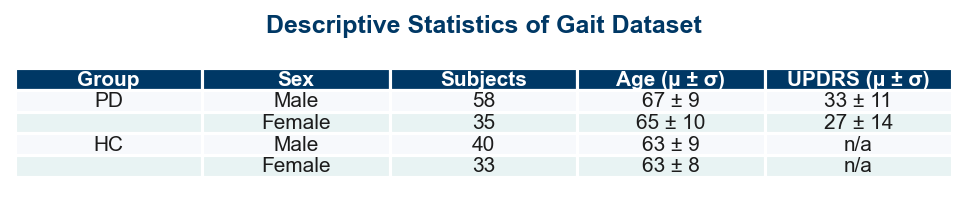

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

# --- Dataset summary ---
data = {
    "Group": ["PD", "", "HC", ""],
    "Sex": ["Male", "Female", "Male", "Female"],
    "Subjects": [58, 35, 40, 33],
    "Age (μ ± σ)": ["67 ± 9", "65 ± 10", "63 ± 9", "63 ± 8"],
    "UPDRS (μ ± σ)": ["33 ± 11", "27 ± 14", "n/a", "n/a"]
}

df = pd.DataFrame(data)

# --- Create figure ---
fig, ax = plt.subplots(figsize=(6.8, 1.7))
ax.axis('off')

# --- Define colors (FAU blue + teal alternating rows) ---
row_colors = ["#E8F3F3" if i % 2 else "#F7F9FC" for i in range(len(df))]
header_color = "#003865"  # FAU deep blue
text_color = "#1C1C1C"

# --- Draw table ---
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center',
)

# --- Style table ---
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.3)

# Header styling
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor(header_color)
        cell.set_text_props(color='white', weight='bold')
    else:
        cell.set_facecolor(row_colors[row-1])
        cell.set_text_props(color=text_color)

# Adjust borders and alignment
for key, cell in table.get_celld().items():
    cell.set_edgecolor('white')

# --- Title ---
plt.title("Descriptive Statistics of Gait Dataset", fontsize=12, weight='bold', pad=12, color='#003865')

plt.tight_layout()
fig.savefig("C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/reports/figs/descriptive_stats_table.png", dpi=450, bbox_inches='tight', transparent=True)
plt.show()

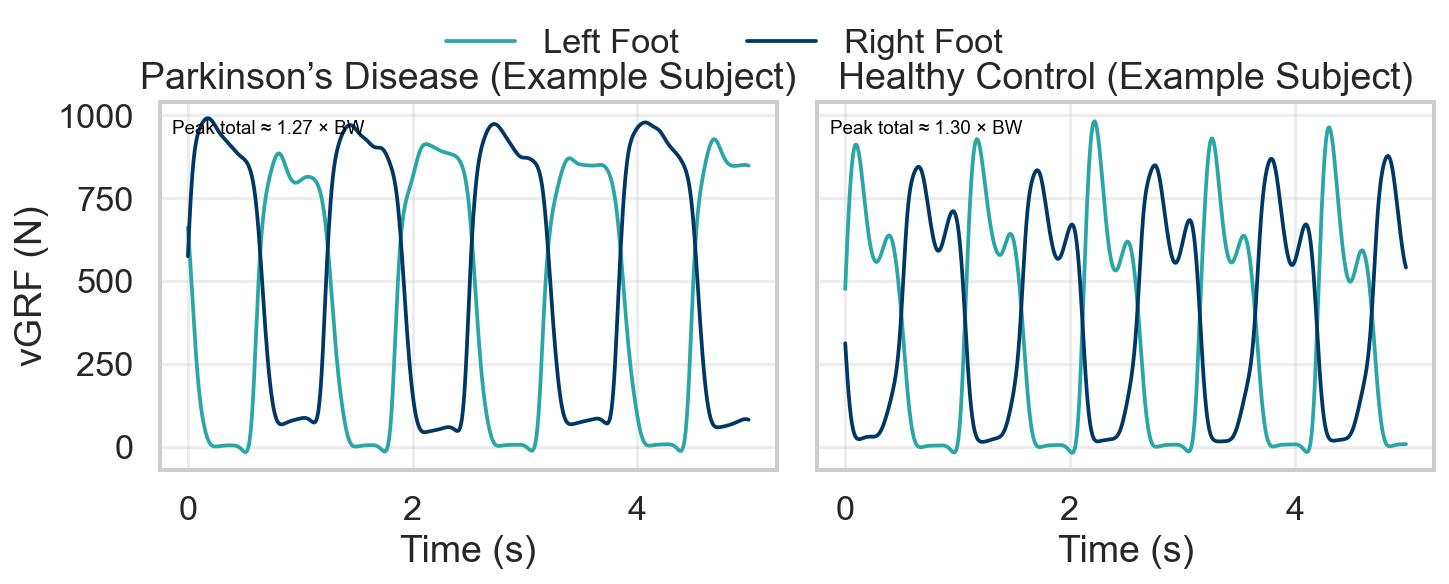

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- your files (usual-walk trials) -----------------
pd_file = "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/data/raw/gait-in-parkinsons-disease-1.0.0/SiPt29_01.txt"
hc_file = "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/data/raw/gait-in-parkinsons-disease-1.0.0/JuCo17_01.txt"

# Optional: if you know subject masses, set; else leave None (we'll just plot Newtons)
MASS_PD_KG = None
MASS_HC_KG = None

# ----------------- constants -----------------
FS = 100                  # Hz
CUT = 6.0                 # low-pass cutoff (Hz)
ORDER = 2                 # Butterworth order
SKIP_S = 3.0              # skip initial seconds (gait initiation)
WIN_S = 5.0               # contiguous window to plot
G = 9.81

# ----------------- helpers -----------------
def check_usual_walk(path):
    name = os.path.basename(path).lower()
    if "_10" in name or "-10" in name:
        print(f"WARNING: {path} looks like dual-task (10). Use _01 for usual walking.")
    if "_01" not in name and "-01" not in name:
        print(f"NOTE: {path} does not explicitly contain 01. Ensure it's a usual-walk trial.")

def load_vgrf_lr(path):
    df = pd.read_csv(path, sep=None, engine="python", header=None)
    # sum of the 8 sensors per foot -> total vGRF (N)
    left  = df.iloc[:, :8].sum(axis=1).to_numpy(float)
    right = df.iloc[:, 8:16].sum(axis=1).to_numpy(float)
    return left, right

def butter_lowpass(x, fs=FS, cutoff=CUT, order=ORDER):
    try:
        from scipy.signal import butter, filtfilt
        b, a = butter(order, cutoff/(0.5*fs), btype="low")
        return filtfilt(b, a, x)
    except Exception:
        # fallback: simple moving average ~ low-pass
        k = max(1, int(fs/(2*cutoff)))  # crude
        w = np.ones(k)/k
        return np.convolve(x, w, mode="same")

def slice_window(x, fs=FS, skip_s=SKIP_S, win_s=WIN_S):
    start = int(skip_s*fs)
    end   = start + int(win_s*fs)
    end = min(end, len(x))
    return x[start:end]

def estimate_bw_from_total(left, right):
    total = left + right
    stance = total[total > 100]  # ignore swing/air
    if stance.size == 0:
        return np.median(total) if total.size else 1.0
    return float(np.median(stance))

# ----------------- load, filter, slice -----------------
for f in (pd_file, hc_file):
    check_usual_walk(f)

pd_L, pd_R = load_vgrf_lr(pd_file)
hc_L, hc_R = load_vgrf_lr(hc_file)

# light filtering
pd_L = butter_lowpass(pd_L); pd_R = butter_lowpass(pd_R)
hc_L = butter_lowpass(hc_L); hc_R = butter_lowpass(hc_R)

# contiguous 5 s after first 3 s
pd_L_w = slice_window(pd_L); pd_R_w = slice_window(pd_R)
hc_L_w = slice_window(hc_L); hc_R_w = slice_window(hc_R)

# time axis in seconds for readability
t = np.arange(len(pd_L_w))/FS
t2 = np.arange(len(hc_L_w))/FS

# optional BW-normalized peaks to annotate (keeps plot in Newtons, just annotate)
bw_pd = MASS_PD_KG*G if MASS_PD_KG else estimate_bw_from_total(pd_L, pd_R)
bw_hc = MASS_HC_KG*G if MASS_HC_KG else estimate_bw_from_total(hc_L, hc_R)
peak_pd_bw = np.max(pd_L_w + pd_R_w)/bw_pd
peak_hc_bw = np.max(hc_L_w + hc_R_w)/bw_hc

# ----------------- plot -----------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].plot(t, pd_L_w, label="Left Foot",  color="#2BA6A6", lw=1.8)
axes[0].plot(t, pd_R_w, label="Right Foot", color="#003865", lw=1.8)
axes[0].set_title("Parkinson’s Disease (Example Subject)")
axes[0].set_xlabel("Time (s)"); axes[0].set_ylabel("vGRF (N)")
axes[0].grid(True, alpha=0.35)
axes[0].text(0.02, 0.95, f"Peak total ≈ {peak_pd_bw:.2f} × BW", transform=axes[0].transAxes,
             ha="left", va="top", fontsize=9, color="black")

axes[1].plot(t2, hc_L_w, label="Left Foot",  color="#2BA6A6", lw=1.8)
axes[1].plot(t2, hc_R_w, label="Right Foot", color="#003865", lw=1.8)
axes[1].set_title("Healthy Control (Example Subject)")
axes[1].set_xlabel("Time (s)")
axes[1].grid(True, alpha=0.35)
axes[1].text(0.02, 0.95, f"Peak total ≈ {peak_hc_bw:.2f} × BW", transform=axes[1].transAxes,
             ha="left", va="top", fontsize=9, color="black")

# place one legend below both axes
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.savefig("C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/reports/figs/vgrf_PD_vs_HC_5s_usualwalk.png", dpi=450, bbox_inches="tight", transparent=True)
plt.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_13708\23172763.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=sep, header=None)
C:\Users\admin\AppData\Local\Temp\ipykernel_13708\23172763.py:29: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(path, sep=sep, header=None)


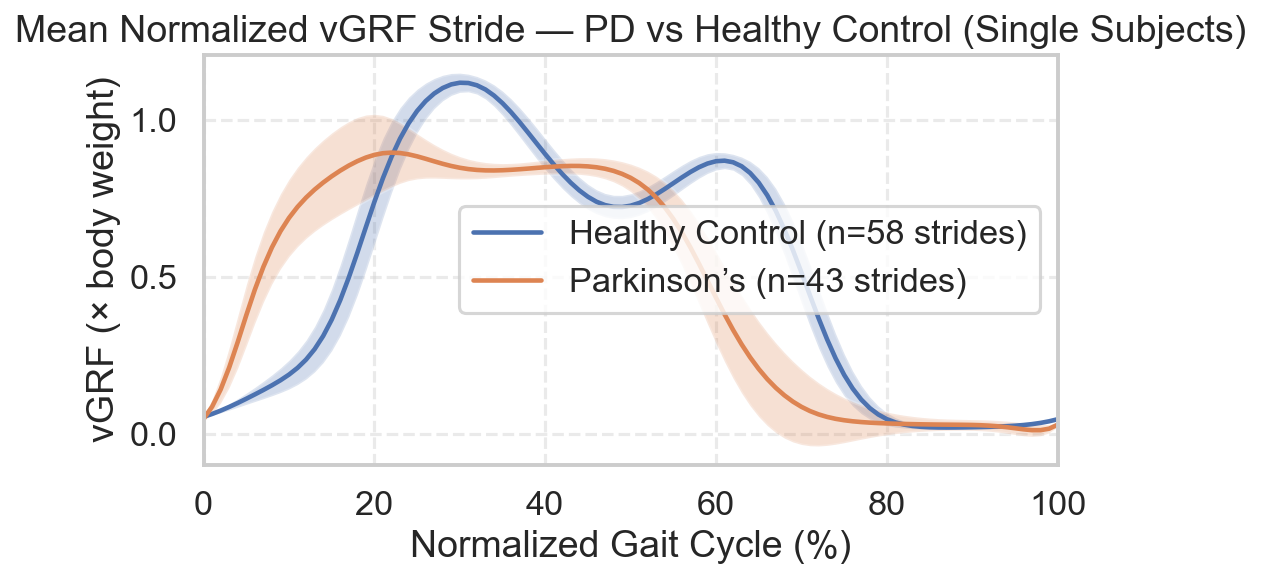

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==== User inputs: set your file paths here ====
PD_FILE = "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/data/raw/gait-in-parkinsons-disease-1.0.0/SiPt29_01.txt"
HC_FILE = "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/data/raw/gait-in-parkinsons-disease-1.0.0/JuCo17_01.txt"

# (Optional) If you know body masses, set them here; else leave as None and BW will be auto-estimated.
MASS_PD_KG = None
MASS_HC_KG = None

# ==== Parameters ====
FS = 100                    # sampling frequency (Hz)
POINTS_PER_CYCLE = 101      # 0..100% stride
MIN_STEP_S = 0.4            # minimum time between heel-strikes (s) to reject false HS
HS_THRESHOLD_N = 40.0       # threshold (N) for heel-strike up-crossing
CUTOFF_HZ = 6.0             # low-pass cutoff for vGRF
G = 9.81                    # gravity (m/s^2)

# ------------------------------------------------
# Helpers
# ------------------------------------------------
def load_subject_vgrf(path, n_sensors_per_foot=8, sep=None):
    """
    Load a GaitPDB subject file and return left and right total vGRF (sum of 8 sensors per foot) in Newtons.
    Files are whitespace/tab delimited.
    """
    df = pd.read_csv(path, sep=sep, header=None)
    left = df.iloc[:, :n_sensors_per_foot].sum(axis=1).to_numpy(dtype=float)
    right = df.iloc[:, n_sensors_per_foot:2*n_sensors_per_foot].sum(axis=1).to_numpy(dtype=float)
    return left, right

def butter_lowpass(x, fs=FS, cutoff=CUTOFF_HZ, order=2):
    from scipy.signal import butter, filtfilt
    b, a = butter(order, cutoff / (0.5*fs), btype='low')
    return filtfilt(b, a, x)

def detect_heel_strikes(vgrf, fs=FS, thres_n=HS_THRESHOLD_N, min_step_s=MIN_STEP_S):
    """
    Heel-strike detection via threshold up-crossings on the chosen foot vGRF.
    """
    above = vgrf > thres_n
    hs = np.where((~above[:-1]) & (above[1:]))[0] + 1
    if hs.size == 0:
        return hs
    min_samples = int(min_step_s * fs)
    kept = [hs[0]]
    for idx in hs[1:]:
        if idx - kept[-1] >= min_samples:
            kept.append(idx)
    return np.asarray(kept, dtype=int)

def strides_from_hs(vgrf, hs, fs=FS, min_len_s=0.8, max_len_s=2.0):
    """
    Segment strides as HS-to-HS windows with plausible duration.
    """
    strides = []
    min_len = int(min_len_s * fs)
    max_len = int(max_len_s * fs)
    for i in range(len(hs)-1):
        a, b = hs[i], hs[i+1]
        seg = vgrf[a:b].astype(float)
        if min_len <= seg.size <= max_len:
            strides.append(seg)
    return strides

def resample_to_percent(stride, n=POINTS_PER_CYCLE):
    x_old = np.linspace(0, 1, stride.size)
    x_new = np.linspace(0, 1, n)
    return np.interp(x_new, x_old, stride)

def summarize_cycles(cycles_2d):
    """
    cycles_2d: array-like of shape (n_cycles, POINTS_PER_CYCLE)
    """
    A = np.vstack(cycles_2d) if isinstance(cycles_2d, list) else cycles_2d
    mu = A.mean(axis=0)
    sd = A.std(axis=0, ddof=1) if A.shape[0] > 1 else np.zeros_like(mu)
    return mu, sd

def estimate_bw_from_total(left_vgrf, right_vgrf):
    """
    Estimate body weight (N) from total vGRF = left+right.
    Use median of total during stance (total > 100 N) as a robust proxy.
    """
    total = left_vgrf + right_vgrf
    stance = total[total > 100.0]
    if stance.size == 0:
        return np.median(total) if total.size else 1.0
    return float(np.median(stance))

def process_subject(file_path, foot="right", mass_kg=None):
    """
    Returns: (mu, sd, n_strides) where mu/sd are 101-point BW-normalized curves for the chosen foot.
    """
    left, right = load_subject_vgrf(file_path)
    # light low-pass
    left = butter_lowpass(left)
    right = butter_lowpass(right)

    # Choose foot; if too few strides, auto-switch to the other
    sig = right if foot.lower().startswith("r") else left
    hs = detect_heel_strikes(sig)
    if len(hs) < 3:
        alt = left if foot.lower().startswith("r") else right
        hs_alt = detect_heel_strikes(alt)
        if len(hs_alt) > len(hs):
            sig, hs = alt, hs_alt

    strides = strides_from_hs(sig, hs)
    if len(strides) == 0:
        return None, None, 0

    # Normalize by body weight
    if mass_kg is not None and mass_kg > 0:
        bw_n = mass_kg * G
    else:
        # auto-estimate BW from total vGRF (left+right) for this subject
        bw_n = estimate_bw_from_total(left, right)
    strides_bw = [s / bw_n for s in strides]

    # Per-subject stride normalization (resample 0..100%) and summary
    cycles = [resample_to_percent(s) for s in strides_bw]
    mu, sd = summarize_cycles(cycles)
    return mu, sd, len(cycles)

# ------------------------------------------------
# Run for one PD and one HC subject
# ------------------------------------------------
pd_mu, pd_sd, pd_n = process_subject(PD_FILE, foot="right", mass_kg=MASS_PD_KG)
hc_mu, hc_sd, hc_n = process_subject(HC_FILE, foot="right", mass_kg=MASS_HC_KG)

if pd_mu is None or hc_mu is None:
    raise RuntimeError("Stride detection failed. Try switching feet or adjust HS_THRESHOLD_N/MIN_STEP_S.")

# ------------------------------------------------
# Plot: Mean normalized stride (0–100%) PD vs HC with ±1 SD (single subjects)
# ------------------------------------------------
x = np.linspace(0, 100, POINTS_PER_CYCLE)

plt.figure(figsize=(7.2, 4.2))
# HC
plt.plot(x, hc_mu, lw=2.2, label=f"Healthy Control (n={hc_n} strides)")
plt.fill_between(x, hc_mu - hc_sd, hc_mu + hc_sd, alpha=0.25)
# PD
plt.plot(x, pd_mu, lw=2.2, label=f"Parkinson’s (n={pd_n} strides)")
plt.fill_between(x, pd_mu - pd_sd, pd_mu + pd_sd, alpha=0.25)

plt.xlim(0, 100)
plt.xlabel("Normalized Gait Cycle (%)")
plt.ylabel("vGRF (× body weight)")
plt.title("Mean Normalized vGRF Stride — PD vs Healthy Control (Single Subjects)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

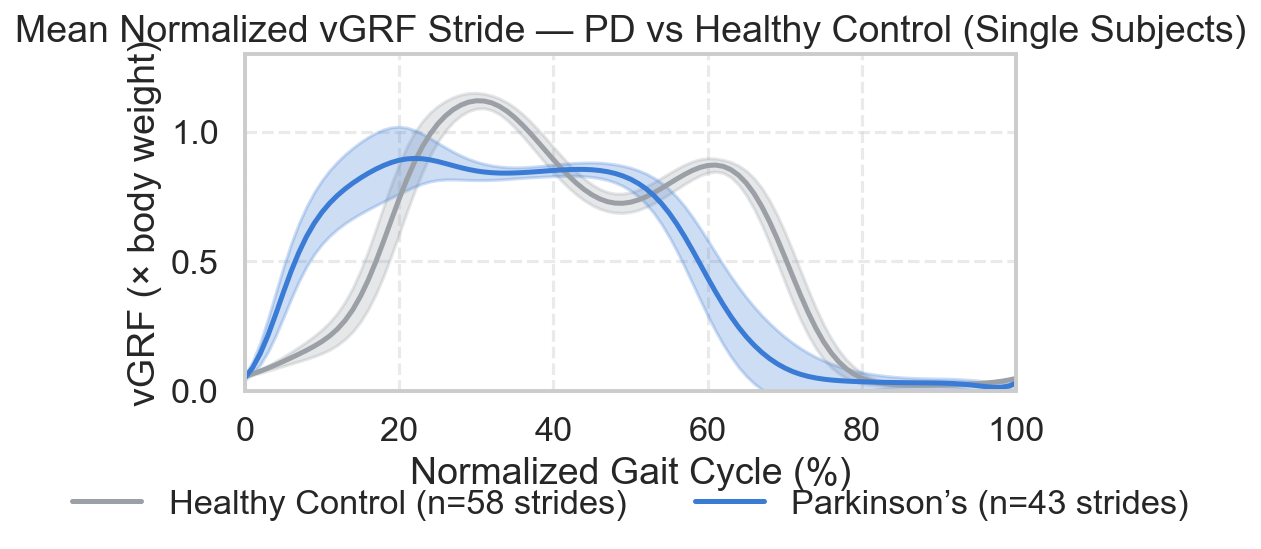

In [12]:
# ------------------------------------------------
# Plot: Mean normalized stride (0–100%) PD vs HC with ±1 SD (single subjects)
# ------------------------------------------------
x = np.linspace(0, 100, POINTS_PER_CYCLE)

plt.figure(figsize=(7.5, 4.2))

# Healthy Control
plt.plot(x, hc_mu, color=COL_HC, lw=2.4, label=f"Healthy Control (n={hc_n} strides)")
plt.fill_between(x, hc_mu - hc_sd, hc_mu + hc_sd, color=COL_HC, alpha=0.25)

# Parkinson’s
plt.plot(x, pd_mu, color=COL_PD, lw=2.4, label=f"Parkinson’s (n={pd_n} strides)")
plt.fill_between(x, pd_mu - pd_sd, pd_mu + pd_sd, color=COL_PD, alpha=0.25)

plt.xlim(0, 100)
plt.ylim(0, 1.3)
plt.xlabel("Normalized Gait Cycle (%)")
plt.ylabel("vGRF (× body weight)")
plt.title("Mean Normalized vGRF Stride — PD vs Healthy Control (Single Subjects)")
plt.grid(True, linestyle="--", alpha=0.4)

# Move legend out of the data region
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.2),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.savefig(outdir / "C:/Users/admin/OneDrive/Desktop/SEM-2-3/Project-Time Series/gait-mamba/reports/figs/mean_normalized_stride_PD_vs_HC.png", dpi=450, bbox_inches="tight", transparent=True)
plt.show()